In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functions import get_filepath, find_clustered_orfs, find_orfs, find_orfs_from_cluster, find_cluster_from_orf
from functions import samples_from_soils, perturbed_pHs, native_pH, enriched_native_pH, perturbed_pH_sample, plot

DATDIR = '/projects/p32818/metagenomic_data/data'

soils = ['Soil3', 'Soil5', 'Soil9', 'Soil11', 'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17'] #no soil 6 here

I will repeat the analysis done on nar and try to find a hierarchical grouping which includes T9 data

/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_12257/818665936.py:3: RuntimeWarning: invalid value encountered in divide
  data = old_data / old_data.sum(axis=1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_12257/818665936.py:12: RuntimeWarning: invalid value encountered in divide
  df = df / df.sum(axis = 1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_12257/818665936.py:12: RuntimeWarning: invalid value encountered in divide
  df = df / df.sum(axis = 1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_12257/818665936.py:12: RuntimeWarning: invalid value encountered in divide
  df = df / df.sum(axis = 1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_12257/818665936.py:12: RuntimeWarning: invalid value encountered in divide
  df = df / df.sum(axis = 1, keepdims=True)
/var/folders/_1/szp4571s76d__d0kyyc1stgc0000gn/T/ipykernel_12257/818665936.py:12: RuntimeWarning: i

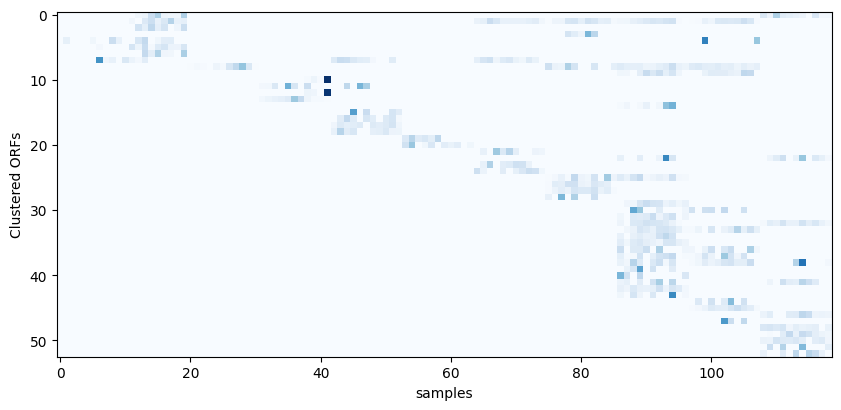

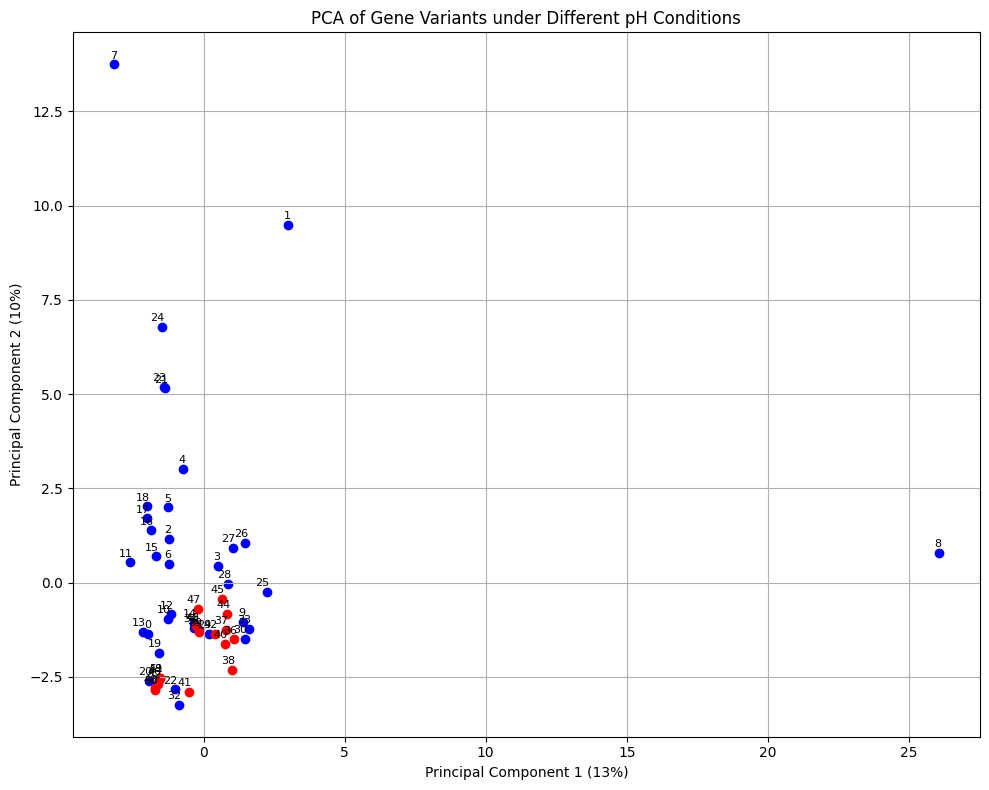

Principal Component 1: 13.14%
Principal Component 2: 8.71%
Principal Component 3: 7.44%
Principal Component 4: 6.42%
Principal Component 5: 6.28%
Principal Component 6: 5.93%
Principal Component 7: 5.51%
Principal Component 8: 4.62%
Principal Component 9: 3.73%
Principal Component 10: 3.17%
Principal Component 11: 2.94%
Principal Component 12: 2.79%
Principal Component 13: 2.65%
Principal Component 14: 2.42%
Principal Component 15: 1.88%
Principal Component 16: 1.68%
Principal Component 17: 1.57%
Principal Component 18: 1.48%
Principal Component 19: 1.41%
Principal Component 20: 1.36%
Principal Component 21: 1.34%
Principal Component 22: 1.21%
Principal Component 23: 1.18%
Principal Component 24: 1.09%
Principal Component 25: 0.95%
Principal Component 26: 0.90%
Principal Component 27: 0.86%
Principal Component 28: 0.81%
Principal Component 29: 0.74%
Principal Component 30: 0.69%


In [7]:
clustered_data = pd.read_csv('out/T0data_08_K02567.tsv', sep='\t', header=None)
old_data = clustered_data.values
data = old_data / old_data.sum(axis=1, keepdims=True)

abs_data = old_data

for soil in soils:
    filename = f"out/{soil}data_08_K02567.tsv"  # Construct the filename
    df = pd.read_csv(filename, sep='\t', header = None)
    df = df.values
    abs_df = df
    df = df / df.sum(axis = 1, keepdims=True)
    abs_data = np.hstack((abs_data, abs_df))
    data = np.hstack((data, df))
    
data = np.nan_to_num(data, nan = 0)

filtered_data = []
absolute_data = []
for i, datum in enumerate(data):
    score = 0
    for entry in datum:
        if entry != 0:
            score += 1
    if score > 0:
        filtered_data.append(datum)
        absolute_data.append(abs_data[i])

        
filtered_data = [list(arr) for arr in filtered_data]
absolute_data = [list(arr) for arr in absolute_data]

plt.figure(figsize=(10,10))
plt.imshow(filtered_data, cmap = 'Blues')
plt.xlabel('samples')
plt.ylabel('Clustered ORFs')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data)

pca = PCA(n_components=30)
principal_components = pca.fit_transform(scaled_data)

# Generate colors based on row index
row_indices = np.arange(principal_components.shape[0])
colors = plt.cm.seismic(row_indices / row_indices.max())

# Plot the first two principal components with row index labels
plt.figure(figsize=(10, 8))
for i in range(principal_components.shape[0]):
    if (i < 35):
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='blue')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')
    if (i > 35):
        plt.scatter(principal_components[i, 0], principal_components[i, 1], color='red')
        plt.text(principal_components[i, 0] + 0.1, principal_components[i, 1] + 0.1 , str(i), fontsize=8, ha='right', va='bottom')


plt.xlabel('Principal Component 1 (13%)')
plt.ylabel('Principal Component 2 (10%)')
plt.title('PCA of Gene Variants under Different pH Conditions')
plt.grid(True)
plt.tight_layout()
plt.show()



for i, ratio in enumerate(pca.explained_variance_ratio_, start=1):
    #plt.scatter(i, ratio)
    print(f"Principal Component {i}: {ratio * 100:.2f}%")

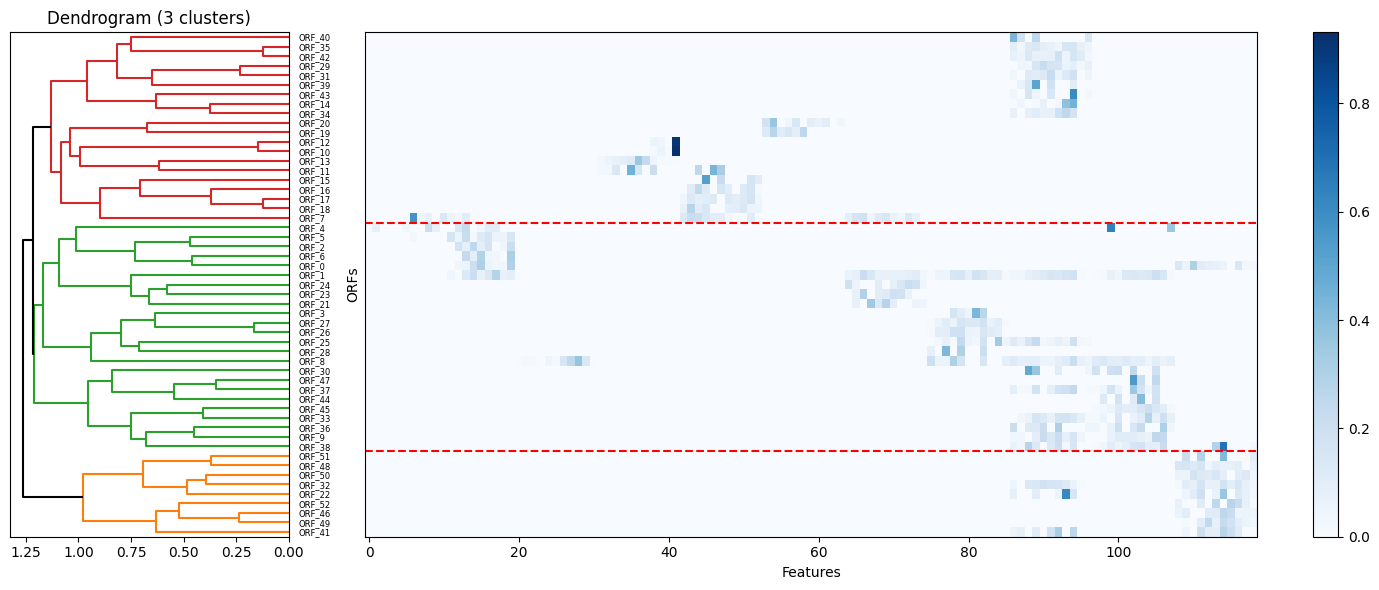

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler


filtered_data = np.array(filtered_data)  

scaler = StandardScaler()
data_scaled = scaler.fit_transform(filtered_data)  

#Hierarchical clustering
Z = linkage(data_scaled, method='complete', metric='correlation')
Z_optimal = optimal_leaf_ordering(Z, pdist(data_scaled, metric='correlation'))


n_clusters = 3
clusters = fcluster(Z_optimal, t=n_clusters, criterion='maxclust')

#leaf ordering
dendro = dendrogram(Z_optimal, no_plot=True)
leaf_indices = dendro['leaves']  


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 4]})


dendrogram(Z_optimal, orientation='left', ax=ax1,
           color_threshold=max(Z_optimal[-n_clusters+1, 2], 0.1),
           above_threshold_color='k',
           labels=[f"ORF_{i}" for i in range(len(filtered_data))])

ax1.set_title(f'Dendrogram ({n_clusters} clusters)')

im = ax2.imshow(filtered_data[leaf_indices], aspect='auto', cmap='Blues',
                interpolation='nearest', origin = 'lower')
plt.colorbar(im, ax=ax2)

#boundaries
boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b+0.5, color='red', linestyle='--')

ax2.set_xlabel('Features')
ax2.set_ylabel('ORFs')
ax2.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
absolute_data = np.array(absolute_data)
filtered_data = np.array(filtered_data)
new_data = filtered_data[leaf_indices]
new_absolute_data = absolute_data[leaf_indices]

print(boundaries)

groups = np.zeros((5,130))

for i, datum in enumerate(new_absolute_data):
    if i < boundaries[0]:
        groups[0] += datum
    elif i > boundaries[0] and i < boundaries[1]:
        groups[1] += datum
    elif i > boundaries[1]:
        groups[2] += datum

        
plt.show()
plt.imshow(groups, cmap = 'Blues', origin = 'lower', aspect = 'auto')
plt.xlabel('samples')
plt.ylabel('groups')
plt.show()

norm_groups = groups / groups.sum(axis=1, keepdims=True)

plt.imshow(norm_groups, cmap = 'Blues', origin = 'lower', aspect = 'auto')
plt.xlabel('samples')
plt.ylabel('groups')
plt.show()



Below is stuff from new haven, where I try to visualize the nap data that we have.

In [ ]:
#For T0, build a plot with rows which are cluster IDs and columns which are Native pH
ORFs = find_orfs(get_filepath('T0', 'annotation'), 'K02567')
ORF_list = list(ORFs)
samples = pd.read_csv(f'{DATDIR}/T0_sampleIDs.tsv', header=None)[0]
sample_list = list(samples)
metadata = pd.read_csv(f'{DATDIR}/metadata.tsv', sep = '\t')
metadata = metadata.set_index('sample')


chunk_size = 100000

data = np.zeros((len(ORFs), 20)) #data for plot stored here, each row is a dinstinct ORF, 

for chunk in pd.read_csv(get_filepath('T0', 'abundance'), sep='\s+', header=None,  chunksize = chunk_size):
    filtered_chunk = chunk[chunk.iloc[:, 1].isin(ORFs)]
    for i in range(len(filtered_chunk)):
        sample_id = filtered_chunk.iloc[i, 0]
        orf = filtered_chunk.iloc[i, 1]
        rel_abundance = filtered_chunk.iloc[i, 2]
        spikein = metadata.loc[sample_id, 'spikein_sum']
        row_idx = ORF_list.index(orf)
        col_idx = sample_list.index(sample_id)
        data[row_idx, col_idx] += rel_abundance/spikein
        
        
absolute_data = data

np.savetxt("out/absolute_data_nap.tsv", np.array(data), delimiter = '\t', fmt = '%.6f')

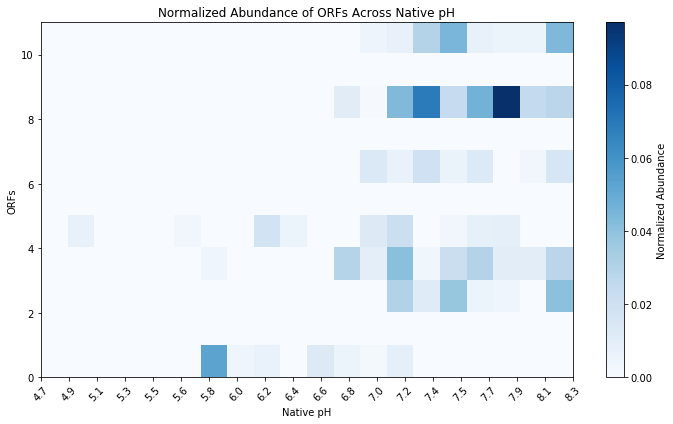

In [4]:
data = pd.read_csv("out/absolute_data_nap.tsv", sep='\t', header=None)
data = data.values
#sorted_data = data[np.argsort(-np.abs(data[:, 0]))]
#normalized_data = sorted_data / sorted_data.sum(axis=1, keepdims=True) #normalization step

x = np.linspace(4.7, 8.3, 20)


plt.figure(figsize=(10, 6))

plt.imshow(data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('ORFs')
plt.title('Normalized Abundance of ORFs Across Native pH')

plt.colorbar(label='Normalized Abundance')

plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#For T0, build a plot with rows which are cluster IDs and columns which are Native pH
ORFs = find_orfs(get_filepath('T0', 'annotation'), 'K02567')
ORF_list = list(ORFs)
print('\n ORFs \n')
print(ORF_list)
Cluster_IDs_nap = ORF_list
for i in range(len(ORF_list)):
    Cluster_IDs_nap[i] = find_cluster_from_orf(ORF_list[i])
    print(Cluster_IDs_nap[i])
print('\n Clusters \n')
print(Cluster_IDs_nap)

IDs = np.array(Cluster_IDs_nap)

sort_indices = np.argsort(-np.abs(data[:, 0])) 

sorted_data = data[sort_indices]
sorted_IDs = IDs[sort_indices]

# Dictionary to accumulate data
id_to_data = {} #given an id, the dictionary spits out the data array
for id, row in zip(sorted_IDs, sorted_data):
    if id in id_to_data:
        id_to_data[id] += row
    else:
        id_to_data[id] = row.copy()

# Reconstruct the arrays
unique_IDs = list(id_to_data.keys())
combined_data = np.array([id_to_data[id] for id in unique_IDs])

np.savetxt("out/cluster_ids_nap.tsv", unique_IDs, delimiter = '\t', fmt = '%s')
np.savetxt("out/clustered_data_nap.tsv", combined_data, delimiter = '\t', fmt = '%0.6f')
    

In [1]:
cluster_IDs = pd.read_csv('out/cluster_ids_nap.tsv', sep='\t', header=None)
clustered_data = pd.read_csv('out/clustered_data_nap.tsv', sep='\t', header=None)
cluster_IDs = cluster_IDs.values
cluster_IDs = [item[0] for item in cluster_IDs]
clustered_data = clustered_data.values
print(cluster_IDs)
print(clustered_data)

normalized_data = clustered_data / clustered_data.sum(axis=1, keepdims=True) #normalization step





plt.figure(figsize=(10, 6))

plt.imshow(normalized_data, aspect='auto', cmap='Blues', extent=[x[0], x[-1], 0, normalized_data.shape[0]])

plt.xlabel('Native pH')
plt.ylabel('Cluster')
plt.title('Normalized Abundance of Clusters Across Native pH')

plt.colorbar(label='Normalized Abundance')
x = np.linspace(4.7, 8.3, 20)
plt.xticks(ticks=np.linspace(x[0], x[-1], len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)

plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]]


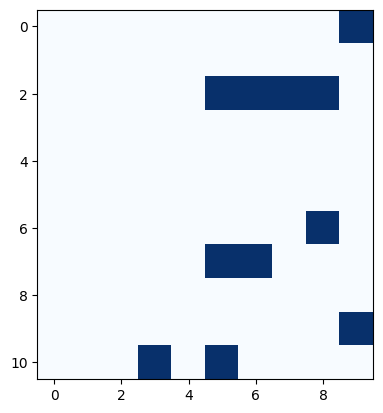

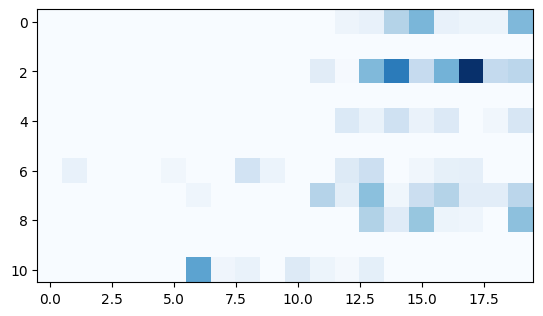

In [8]:
tracking = pd.read_csv('out/track_clusters_nap.tsv', sep = '\t', header = None)
tracking = tracking.values
print(tracking)
plt.imshow(tracking, origin = 'upper', cmap = 'Blues')

clustered_data = pd.read_csv('out/clustered_data_nap.tsv', sep='\t', header=None)
data = clustered_data.values
plt.show()
plt.imshow(data, origin = 'upper', cmap = 'Blues')
plt.show()


Problem: Nap has very little data. But, we need Nap, because it is in the periplasm so maybe it actually responds to the pH perturbation. 

Solution: Long term: do a better (less fine) sequence clustering. this is running. 

Short term: See if we can make the most out of this data. First, cut out the columns of the T0 plot which we don't have T9 data for. Then, cut out the rows which we don't have both T0 and T9 data for. Some rows we have no data for. 

Then, for each of the 5 allelic variants which we have any data for, compile that data. 

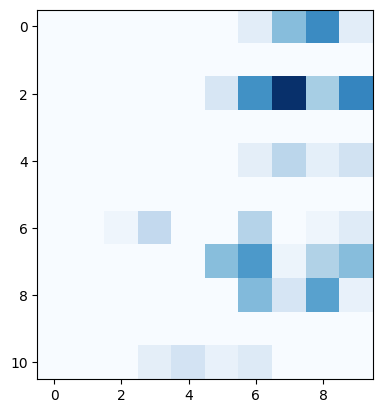

In [9]:
#first, select the columns which we have T9 data for.
selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
data = data[:, selected]
plt.imshow(data, origin = 'upper', cmap = 'Blues')
plt.show()

In [10]:
#then, select rows which we have T0 and T9 data for. 
rows_selected = [0, 2, 6, 7, 10]
data = data[rows_selected]

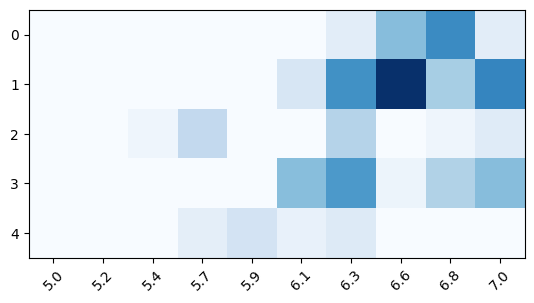

In [ ]:
plt.imshow(data, origin = 'upper', cmap = 'Blues')
x = np.linspace(5, 7, 10)
plt.xticks(ticks=np.linspace(0, 9, len(x)), labels=[f"{val:.1f}" for val in x], rotation=45)
plt.show()



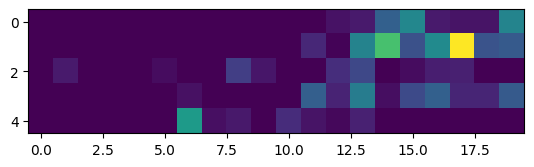

In [15]:
#Sometimes we'll want all of the columns but not all of the rows. 
clustered_data = pd.read_csv('out/clustered_data_nap.tsv', sep='\t', header=None)
data = clustered_data.values
native_data = data[rows_selected]
plt.imshow(native_data)

Variant 1

row 0 of original data

Only T9 data is available for Soil 17

[0.001843 0.009689 0.001576 0.       0.005002 0.005805 0.007439 0.020767
 0.003662 0.009493 0.003744]
[4.135, 4.495, 4.892, 5.553, 5.853, 6.201, 6.622, 7.603, 7.943, 8.339, 8.45]


Text(0, 0.5, 'Absolute Abundance')

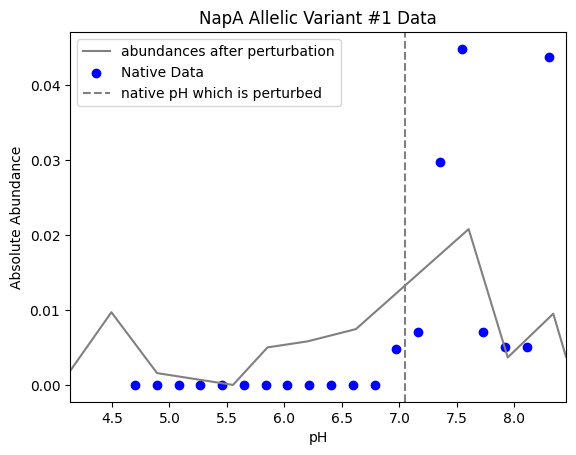

In [81]:
data = pd.read_csv('out/Soil17data_nap.tsv', sep = '\t', header = None)
data = data.values
print(data[0])
y = data[0]
x = perturbed_pHs('Soil17')
print(x)
plt.plot(x, y, color = 'gray', label = 'abundances after perturbation')
x2 = np.linspace(4.7, 8.3, 20)
y2 = native_data[0]
plt.scatter(x2, y2, color = 'blue', label = 'Native Data')
plt.axvline(x = native_pH('Soil17'), color = 'gray', linestyle = '--', label = 'native pH which is perturbed')
plt.legend()
plt.title('NapA Allelic Variant #1 Data')
plt.xlim(min(x), max(x))
plt.xlabel('pH')
plt.ylabel('Absolute Abundance')

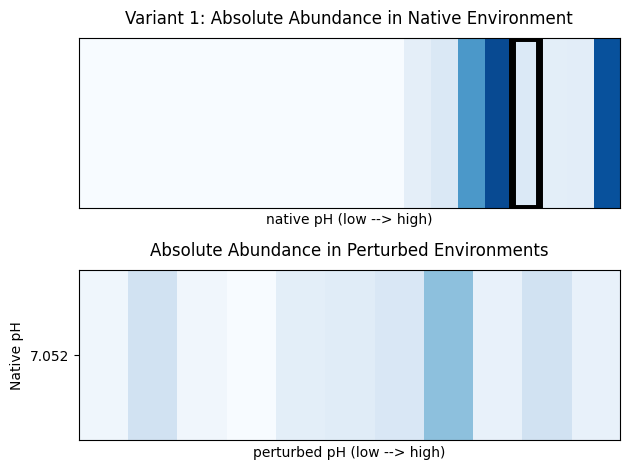

In [99]:
import matplotlib.patches as patches

variant1data = np.zeros((1, 11))
natdata= native_data[0]

data = pd.read_csv('out/Soil17data_nap.tsv', sep = '\t', header = None)
data = data.values
variant1data[0] = data[0]


fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

ax1.imshow([natdata], aspect='auto', cmap = 'Blues', extent=[0, 20, 0, 1], vmin = 0, vmax = 0.05)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('native pH (low --> high)')

ax1.set_title('Variant 1: Absolute Abundance in Native Environment', pad=10) 

highlight_x = 16
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)


# Other rows (bottom subplot)
ax2.imshow(variant1data, aspect='auto', cmap = 'Blues', extent=[0, 10, 0, 1], vmin = 0, vmax = 0.05)
ax2.set_xticks([])
ax2.set_ylabel('Native pH')
ax2.set_yticks([0.5], labels=[native_pH('Soil17')])
ax2.set_xlabel('perturbed pH (low --> high)')

ax2.set_title('Absolute Abundance in Perturbed Environments', pad=10) 

plt.tight_layout()
plt.show()


Variant 2

row 2 of original data

We have perturbed data for 4 native pHs (12,14,15,16) / (5,6,7,8).

But the above plot looks stupid, so I need a new method of plotting. Going to show plt.imshow() style.

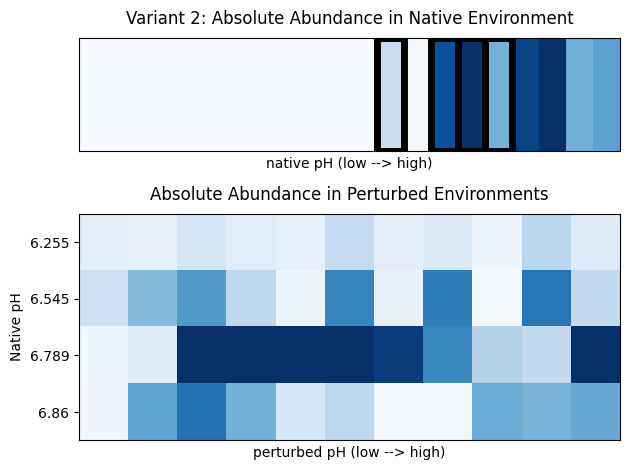

In [100]:
import matplotlib.patches as patches

variant2data = np.zeros((4, 11))
natdata= native_data[1]

data = pd.read_csv('out/Soil12data_nap.tsv', sep = '\t', header = None)
data = data.values
variant2data[0] = data[2]

data = pd.read_csv('out/Soil14data_nap.tsv', sep = '\t', header = None)
data = data.values
variant2data[1] = data[2]

data = pd.read_csv('out/Soil15data_nap.tsv', sep = '\t', header = None)
data = data.values
variant2data[2] = data[2]

data = pd.read_csv('out/Soil16data_nap.tsv', sep = '\t', header = None)
data = data.values
variant2data[3] = data[2]


fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})

ax1.imshow([natdata], aspect='auto', cmap = 'Blues', extent=[0, 20, 0, 1], vmin = 0, vmax = 0.05)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('native pH (low --> high)')

ax1.set_title('Variant 2: Absolute Abundance in Native Environment', pad=10) 

highlight_x = 11
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)

highlight_x = 13
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)

highlight_x = 14
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)

highlight_x = 15
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)

# Other rows (bottom subplot)
ax2.imshow(variant2data, aspect='auto', cmap = 'Blues', extent=[0, 10, 0, 4], vmin = 0, vmax = 0.05)
ax2.set_xticks([])
ax2.set_ylabel('Native pH')
ax2.set_yticks([3.5, 2.5, 1.5, 0.5], labels=[native_pH('Soil12'), native_pH('Soil14'), native_pH('Soil15'), native_pH('Soil16')])
ax2.set_xlabel('perturbed pH (low --> high)')

ax2.set_title('Absolute Abundance in Perturbed Environments', pad=10) 

plt.tight_layout()
plt.show()


Variant 3

row 6 of original data

We only have perturbed data for Soil 16

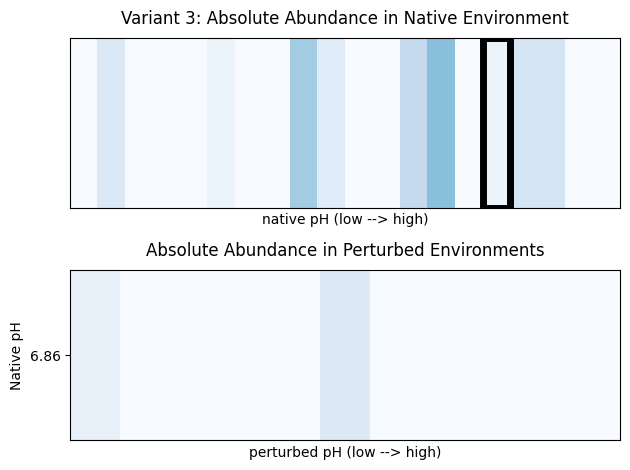

In [101]:
import matplotlib.patches as patches

variant3data = np.zeros((1, 11))
natdata = native_data[2]

data = pd.read_csv('out/Soil16data_nap.tsv', sep = '\t', header = None)
data = data.values
variant3data[0] = data[6]


fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

ax1.imshow([natdata], aspect='auto', cmap = 'Blues', extent=[0, 20, 0, 1], vmin = 0, vmax = 0.05)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('native pH (low --> high)')

ax1.set_title('Variant 3: Absolute Abundance in Native Environment', pad=10) 

highlight_x = 15
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)


# Other rows (bottom subplot)
ax2.imshow(variant3data, aspect='auto', cmap = 'Blues', extent=[0, 10, 0, 1], vmin = 0, vmax = 0.05)
ax2.set_xticks([])
ax2.set_ylabel('Native pH')
ax2.set_yticks([0.5], labels=[native_pH('Soil16')])
ax2.set_xlabel('perturbed pH (low --> high)')

ax2.set_title('Absolute Abundance in Perturbed Environments', pad=10) 

plt.tight_layout()
plt.show()


Variant 4

Row 7 in original data

We have data for soils 12 and 14

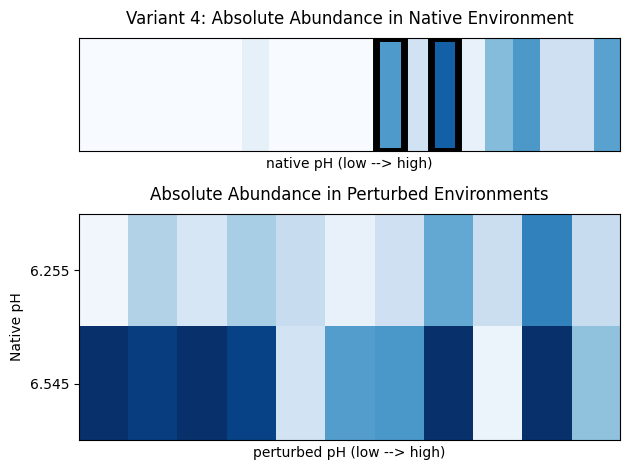

In [102]:
import matplotlib.patches as patches

variant4data = np.zeros((2, 11))
natdata= native_data[3]

data = pd.read_csv('out/Soil12data_nap.tsv', sep = '\t', header = None)
data = data.values
variant4data[0] = data[7]

data = pd.read_csv('out/Soil14data_nap.tsv', sep = '\t', header = None)
data = data.values
variant4data[1] = data[7]



fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})

ax1.imshow([natdata], aspect='auto', cmap = 'Blues', extent=[0, 20, 0, 1], vmin = 0, vmax = 0.05)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('native pH (low --> high)')

ax1.set_title('Variant 4: Absolute Abundance in Native Environment', pad=10) 

highlight_x = 11
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)

highlight_x = 13
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)

# Other rows (bottom subplot)
ax2.imshow(variant4data, aspect='auto', cmap = 'Blues', extent=[0, 10, 0, 4], vmin = 0, vmax = 0.05)
ax2.set_xticks([])
ax2.set_ylabel('Native pH')
ax2.set_yticks([3, 1], labels=[native_pH('Soil12'), native_pH('Soil14')])
ax2.set_xlabel('perturbed pH (low --> high)')

ax2.set_title('Absolute Abundance in Perturbed Environments', pad=10) 

plt.tight_layout()
plt.show()


Variant 5

row 10 in the original data

present in soils 9 and 12

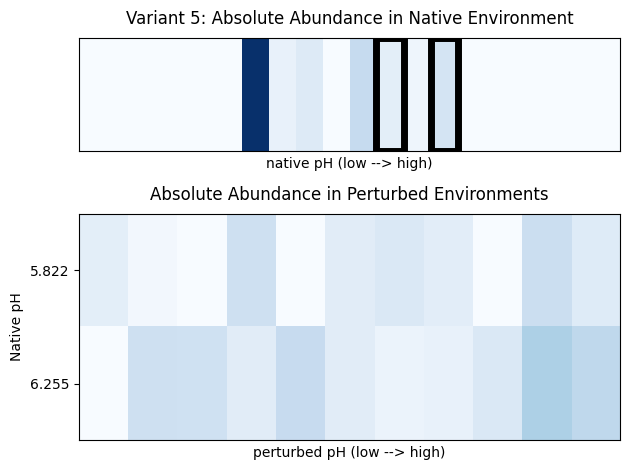

In [103]:
import matplotlib.patches as patches

variant5data = np.zeros((2, 11))
natdata= native_data[4]

data = pd.read_csv('out/Soil9data_nap.tsv', sep = '\t', header = None)
data = data.values
variant5data[0] = data[10]

data = pd.read_csv('out/Soil12data_nap.tsv', sep = '\t', header = None)
data = data.values
variant5data[1] = data[10]



fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})

ax1.imshow([natdata], aspect='auto', cmap = 'Blues', extent=[0, 20, 0, 1], vmin = 0, vmax = 0.05)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('native pH (low --> high)')

ax1.set_title('Variant 5: Absolute Abundance in Native Environment', pad=10) 

highlight_x = 11
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)

highlight_x = 13
rect = patches.Rectangle(
    (highlight_x, 0),  # (x, y) of lower-left corner
    1,  # width
    1,  # height
    linewidth=5,
    edgecolor='black',
    facecolor='none'
)
ax1.add_patch(rect)

# Other rows (bottom subplot)
ax2.imshow(variant5data, aspect='auto', cmap = 'Blues', extent=[0, 10, 0, 4], vmin = 0, vmax = 0.05)
ax2.set_xticks([])
ax2.set_ylabel('Native pH')
ax2.set_yticks([3, 1], labels=[native_pH('Soil9'), native_pH('Soil12')])
ax2.set_xlabel('perturbed pH (low --> high)')

ax2.set_title('Absolute Abundance in Perturbed Environments', pad=10) 

plt.tight_layout()
plt.show()
